## Example NoiseGrad and NoiseGrad++ text-classification

With a few lines of code we show how to use NoiseGrad and NoiseGrad++ with PyTorch, as a way to enhance text-classification explanation method.

• **Paper:** NoiseGrad: enhancing explanations by introducing stochasticity to model weights
• **Author:** Artem Sereda
• **Institution:** TU Berlin, ML Department, Understandable Machine Intelligence Lab
• **Date:** February, 2023


In [14]:
import torch
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from noisegrad import NoiseGrad, NoiseGradPlusPlus, utils, explainers
from functools import partial
from IPython.core.display import HTML

device = torch.device("cpu")

### Step 1. Load data and model

In [2]:
x_batch = [load_dataset("sst2")["test"]["sentence"][2]]
x_batch

Found cached dataset sst2 (/Users/artemsereda/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

['by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .']

In [21]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

In [22]:
input_ids = tokenizer(x_batch, return_tensors="pt")["input_ids"]

In [30]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy().tolist()[0])

In [24]:
y_batch = model(input_ids).logits.detach().argmax(axis=-1)

In [25]:
def embedding_lookup(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.int64, device=input_ids.device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    word_embeddings = model.get_input_embeddings()(input_ids)
    position_embeddings = model.get_position_embeddings()(position_ids)
    return word_embeddings + position_embeddings


x_batch_embeddings = embedding_lookup(input_ids)

### Step 2. Initialize methods

In [26]:
ng = NoiseGrad(n=5)
ng_pp = NoiseGradPlusPlus(n=5, m=5)

### Step 3. Get explanations

In [33]:
baseline_scores = explainers.explain_gradient_x_input(
    model, x_batch_embeddings, y_batch, attention_mask=None
).numpy()

In [41]:
ng_scores = ng.enhance_explanation(
    model,
    x_batch_embeddings,
    y_batch,
    explanation_fn=partial(explainers.explain_gradient_x_input, attention_mask=None),
).numpy()

[-0.14382413 -0.03755875 -0.04076904 -0.02317943 -0.00193062 -0.01809819
  0.03267343 -0.03525239 -0.04072919 -0.02667771 -0.01746889 -0.00748885
 -0.02299407 -0.00076448 -0.00658398  0.00240471 -0.0346409  -0.03986435
 -0.03223591  0.03884006 -0.03920429  0.02058545 -0.01509696 -0.20311876]


In [35]:
ng_pp_scores = ng_pp.enhance_explanation(
    model,
    x_batch_embeddings,
    y_batch,
    explanation_fn=partial(explainers.explain_gradient_x_input, attention_mask=None),
).numpy()

NoiseGrad++:   0%|          | 0/25 [00:00<?, ?it/s]

### Step 4. Visualize explanations

/var/folders/z_/0m6v5by50hz7hm8_bfck_0gm0000gp/T/ipykernel_63076/197219540.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


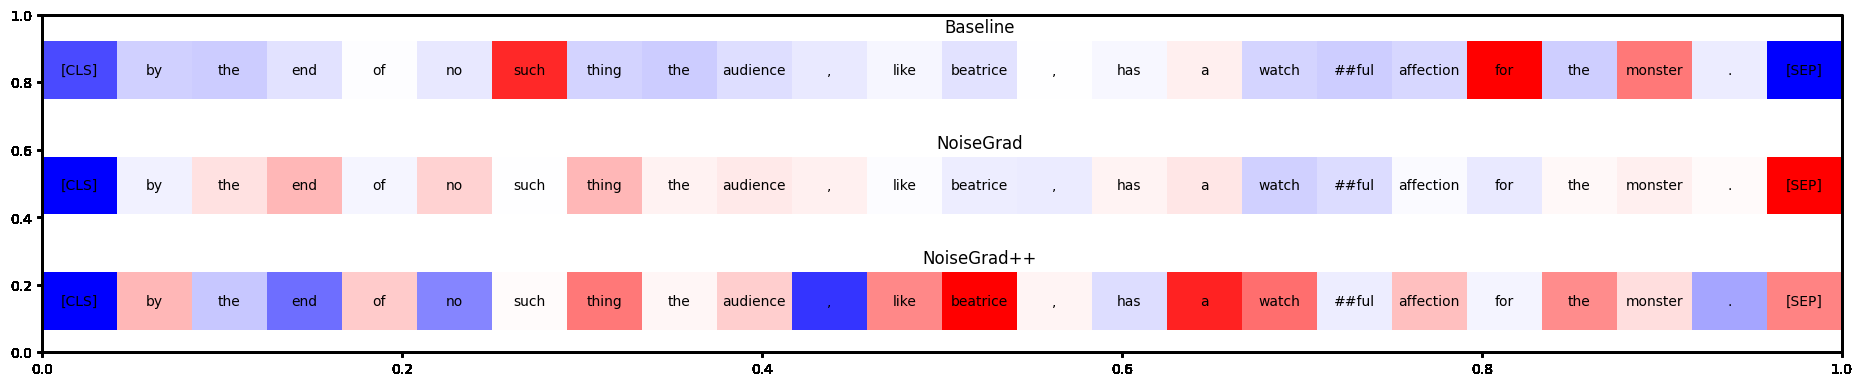

In [62]:
HTML(
    utils.visualise_explanations_as_html(
        [
            (tokens, baseline_scores[0]),
            (tokens, ng_scores[0]),
            (tokens, ng_pp_scores[0]),
        ],
        ignore_special_tokens=True,
        labels=["Baseline", "NoiseGrad", "NoiseGrad++"],
    )
)